In [1]:
%run common.ipynb

['LC_Type1', 'LST_Day_1km', 'pr', 'aet', 'NDVI', 'EVI']
['LST_Day_1km', 'pr', 'aet', 'NDVI', 'EVI']
['LC_Type1']


In [2]:
%run tuning_common.ipynb

Using TensorFlow backend


In [3]:
MODEL_SAVE_DIR = f'{UPSTREAM_FINETUNE_DIR}model'

In [4]:
upstream_train_df = pd.read_csv(f'{DATA_FOLDER}{UPSTREAM_TRAIN_FILENAME}')
upstream_val_df = pd.read_csv(f'{DATA_FOLDER}{UPSTREAM_VAL_FILENAME}')
print(len(upstream_train_df))
print(upstream_train_df.head())
print(len(upstream_val_df))
print(upstream_val_df.head())

141623
   LC_Type1  LST_Day_1km        pr       aet      NDVI       EVI      Gpp
0      12.0    -0.064955  0.092342  0.308087  0.224185  0.727549   9841.0
1      12.0    -0.192976  0.049550  0.340180  0.243270  0.558092  10251.0
2      14.0    -0.149169  0.150901  0.378263  0.483407  0.886860  11607.0
3       9.0    -0.216264  0.454955  0.118528  0.455776  0.549467  12098.0
4       5.0    -0.251888  0.112613  0.357724  0.441817  0.393201  13593.0
23624
   LC_Type1  LST_Day_1km        pr       aet      NDVI       EVI      Gpp
0      12.0    -0.159366  0.513513  0.552418  0.288563  0.770675  11278.0
1      12.0    -0.136329  0.612613  0.493795  0.221051  0.611872   9801.0
2      12.0    -0.034743  0.536036  0.597775  0.144709  0.299340   8328.0
3      14.0    -0.075529  0.774775  0.693196  0.297394  0.671233   9543.0
4       5.0    -0.434290  1.313063  0.653402  0.452072  0.118214  11667.0


In [5]:
upstream_train_df = embed_catgorical_features(upstream_train_df, CATEGORICAL_FEATURES)
upstream_val_df = embed_catgorical_features(upstream_val_df, CATEGORICAL_FEATURES)

In [6]:
upstream_train_tf = df_to_dataset(upstream_train_df[FEATURES + [TARGET_FEATURE]], TARGET_FEATURE, shuffle=True, batch_size=512)
upstream_val_tf = df_to_dataset(upstream_val_df[FEATURES + [TARGET_FEATURE]], TARGET_FEATURE, shuffle=False, batch_size=512)

/home/zheng.yant/ML-LUE/fttransformer/utils/preprocessing.py:21: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dataset[key] = value[:, tf.newaxis]
/home/zheng.yant/ML-LUE/fttransformer/utils/preprocessing.py:21: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dataset[key] = value[:, tf.newaxis]


In [7]:
class MyHyperModel(keras_tuner.HyperModel):
    def __init__(self, df_train):
        self.df_train = df_train
        
    def build(self, hp):
        d_embedding = hp.Int("d_embedding", min_value=32, max_value=512, step=8)
        n_layers = hp.Int("n_layers", min_value=1, max_value=8)
        ffn_factor = hp.Float("ffn_factor", min_value=2/3, max_value=8/3, sampling="linear")
        attention_dropout = hp.Float("attention_dropout", min_value=0.0, max_value=0.5, sampling="linear")
        ffn_dropout = hp.Float("ffn_dropout", min_value=0.0, max_value=0.5, sampling="linear")
        residual_dropout = hp.Float("residual_dropout", min_value=0.0, max_value=0.2, default=0.0, sampling="linear")

        lr = hp.Float("lr", min_value=1e-5, max_value=1e-2, sampling="log")
        weight_decay = hp.Float("weight_decay", min_value=1e-6, max_value=1e-3, sampling="log")
        
        mlp_head_unit_1 = hp.Int("mlp_head_unit_1", min_value=16, max_value=128, step=8)
        mlp_head_unit_2 = hp.Int("mlp_head_unit_2", min_value=16, max_value=128, step=8)

        model = compile_model(
            self.df_train,
            d_embedding=d_embedding, 
            n_layers=n_layers, 
            ffn_factor=ffn_factor,
            attention_dropout=attention_dropout,
            ffn_dropout=ffn_dropout,
            residual_dropout=residual_dropout,
            weight_decay=weight_decay,
            lr=lr,
            mlp_head_unit_1=mlp_head_unit_1,
            mlp_head_unit_2=mlp_head_unit_2
        )
        return model

In [8]:
import json
import os.path


class CustomCallback(tf.keras.callbacks.Callback):
    static_cur_best_result = np.Inf
    def __init__(
        self,
        filepath,
        log_dump_filepath,
        monitor: str = "val_loss",
        mode: str = "auto",
        **kwargs,
    ):
        self.checkpoint = tf.keras.callbacks.ModelCheckpoint(
                                monitor=monitor,
                                mode=mode,
                                save_best_only=True,
                                filepath=filepath)
        self.log_dump_filepath = log_dump_filepath
        if os.path.exists(self.log_dump_filepath):
            with open(self.log_dump_filepath) as f: 
                data = f.read() 
                di = json.loads(data) 
                CustomCallback.static_cur_best_result = di['best_result']
                print(f'read best result {CustomCallback.static_cur_best_result} from {self.log_dump_filepath}')

    def set_params(self, params):
        self.checkpoint.set_params(params)

    def set_model(self, model):
        self.checkpoint.set_model(model)
    
    def on_train_begin(self, logs=None):
        self.checkpoint.on_train_begin(logs)

    def on_train_end(self, logs=None):
        keys = list(logs.keys())

    def on_epoch_begin(self, epoch, logs=None):
        self.checkpoint.on_epoch_begin(epoch, logs)

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.checkpoint.monitor) 
        if self.checkpoint.monitor_op(current, CustomCallback.static_cur_best_result):
            print('+++++ Get a better result, save the model +++++')
            self.checkpoint.on_epoch_end(epoch, logs)
            CustomCallback.static_cur_best_result = current
            # Data to be written
            dictionary = {
                "best_result": current,
            }

            # Serializing json
            json_object = json.dumps(dictionary, indent=4)
            with open(self.log_dump_filepath, "w") as outfile:
                json.dump(dictionary, outfile)
        else:
            print('+++++ Not as good as the best so far, no saving +++++')
            self.checkpoint.epochs_since_last_save += 1

            

    def on_train_batch_end(self, batch, logs=None):
        self.checkpoint.on_train_batch_end(batch, logs)


In [9]:
callbacks = [
    CustomCallback(
        monitor=finetune_objective[0].name,
        mode=finetune_objective[0].direction,
        filepath=MODEL_SAVE_DIR,
        log_dump_filepath=f'{UPSTREAM_FINETUNE_DIR}log_best_result.txt',
    )
]

In [10]:
hp = keras_tuner.HyperParameters()

In [11]:
def start_fine_tune(objective, epochs=10, max_trials=20, overwrite=False):
    tf.keras.backend.clear_session()
    m = MyHyperModel(upstream_train_df)
    tuner = get_random_search_instance(objective, UPSTREAM_FINETUNE_DIR, overwrite, m, max_trials=max_trials)
    tuner.search(upstream_train_tf, validation_data=upstream_val_tf, epochs=epochs, callbacks=callbacks)
    return tuner

## Fine tune with RMSE

### Fine tune

In [ ]:
tuner = start_fine_tune(finetune_objective, epochs=100, max_trials=3)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
472               |472               |d_embedding
1                 |1                 |n_layers
1.0876            |1.0876            |ffn_factor
0.15127           |0.15127           |attention_dropout
0.45905           |0.45905           |ffn_dropout
0.062671          |0.062671          |residual_dropout
0.0030623         |0.0030623         |lr
1.2101e-05        |1.2101e-05        |weight_decay
16                |16                |mlp_head_unit_1
96                |96                |mlp_head_unit_2

Epoch 1/100
277/277 [==============================] - ETA: 0s - loss: 107705664.0000 - importances_loss: 97134328.0000 - output_loss: 10571315.0000 - importances_root_mean_squared_error: 9855.6729 - output_root_mean_squared_error: 3251.3560+++++ Get a better result, save the model +++++


277/277 [==============================] - 292s 1s/step - loss: 107705664.0000 - importances_loss: 97134328.0000 - output_loss: 10571315.0000 - importances_root_mean_squared_error: 9855.6729 - output_root_mean_squared_error: 3251.3560 - val_loss: 102116648.0000 - val_importances_loss: 97465104.0000 - val_output_loss: 4651543.5000 - val_importances_root_mean_squared_error: 9872.4414 - val_output_root_mean_squared_error: 2156.7437
Epoch 2/100
277/277 [==============================] - 294s 1s/step - loss: 103900232.0000 - importances_loss: 97134320.0000 - output_loss: 6765885.0000 - importances_root_mean_squared_error: 9855.6738 - output_root_mean_squared_error: 2601.1316 - val_loss: 102738080.0000 - val_importances_loss: 97465104.0000 - val_output_loss: 5272968.0000 - val_importances_root_mean_squared_error: 9872.4414 - val_output_root_mean_squared_error: 2296.2944
Epoch 3/100
277/277 [==============================] - 272s 979ms/step - loss: 103856200.0000 - importances_loss: 97134344.

277/277 [==============================] - 256s 922ms/step - loss: 101995728.0000 - importances_loss: 97134304.0000 - output_loss: 4861394.0000 - importances_root_mean_squared_error: 9855.6758 - output_root_mean_squared_error: 2204.8569 - val_loss: 101670928.0000 - val_importances_loss: 97465104.0000 - val_output_loss: 4205831.5000 - val_importances_root_mean_squared_error: 9872.4414 - val_output_root_mean_squared_error: 2050.8125
Epoch 11/100
277/277 [==============================] - ETA: 0s - loss: 101245304.0000 - importances_loss: 97134360.0000 - output_loss: 4110988.7500 - importances_root_mean_squared_error: 9855.6738 - output_root_mean_squared_error: 2027.5574+++++ Get a better result, save the model +++++


277/277 [==============================] - 259s 934ms/step - loss: 101245304.0000 - importances_loss: 97134360.0000 - output_loss: 4110988.7500 - importances_root_mean_squared_error: 9855.6738 - output_root_mean_squared_error: 2027.5574 - val_loss: 101224576.0000 - val_importances_loss: 97465104.0000 - val_output_loss: 3759474.2500 - val_importances_root_mean_squared_error: 9872.4414 - val_output_root_mean_squared_error: 1938.9364
Epoch 12/100
277/277 [==============================] - ETA: 0s - loss: 101017904.0000 - importances_loss: 97134304.0000 - output_loss: 3883609.2500 - importances_root_mean_squared_error: 9855.6768 - output_root_mean_squared_error: 1970.6875+++++ Get a better result, save the model +++++


277/277 [==============================] - 270s 971ms/step - loss: 101017904.0000 - importances_loss: 97134304.0000 - output_loss: 3883609.2500 - importances_root_mean_squared_error: 9855.6768 - output_root_mean_squared_error: 1970.6875 - val_loss: 101001864.0000 - val_importances_loss: 97465104.0000 - val_output_loss: 3536768.7500 - val_importances_root_mean_squared_error: 9872.4414 - val_output_root_mean_squared_error: 1880.6299
Epoch 13/100
277/277 [==============================] - 250s 902ms/step - loss: 101481544.0000 - importances_loss: 97134376.0000 - output_loss: 4347191.0000 - importances_root_mean_squared_error: 9855.6758 - output_root_mean_squared_error: 2084.9919 - val_loss: 101233232.0000 - val_importances_loss: 97465104.0000 - val_output_loss: 3768124.5000 - val_importances_root_mean_squared_error: 9872.4414 - val_output_root_mean_squared_error: 1941.1658
Epoch 14/100
277/277 [==============================] - 249s 896ms/step - loss: 101443128.0000 - importances_loss: 97

### Load best results and predict

In [7]:
model_reload = tf.keras.models.load_model(MODEL_SAVE_DIR)
get_rmse_on_upstream_val(model_reload, upstream_val_df)

In [9]:
downstream_test_df = pd.read_csv(f'{DATA_FOLDER}{DOWNSTREAM_TEST_FILENAME}')
downstream_test_df = embed_catgorical_features(downstream_test_df, CATEGORICAL_FEATURES)

In [10]:
predict_results = get_predict_result(model_reload, downstream_test_df[FEATURES], downstream_test_df[TARGET_FEATURE])
fluxnet_modis_test_df = get_modis_compare_data(predict_results['output'].ravel())
get_modis_result(fluxnet_modis_test_df[TARGET_FEATURE], downstream_test_df[TARGET_FEATURE])

 28/160 [====>.........................] - ETA: 0s

/home/zheng.yant/ML-LUE/fttransformer/utils/preprocessing.py:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dataset[key] = value[:, tf.newaxis]


160/160 [==============================] - 4s 24ms/step
Linear Encoding RMSE: 4903.9177
MOD17 RMSE: 4586.4354


<ipython-input-2-73ed0f6d1bee>:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-g" (-> color='g'). The keyword argument will take precedence.
  plt.plot(actual_df, actual_df, '-g', color='red')


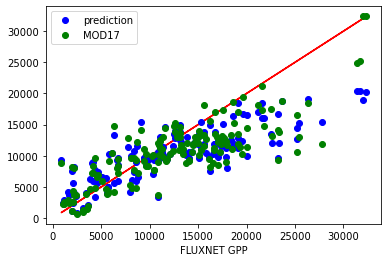

In [11]:
plot_result_distribution(downstream_test_df[TARGET_FEATURE], predict_results['output'].ravel(), fluxnet_modis_test_df[TARGET_FEATURE])